In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
import sklearn
import os

**Kaggle**

Getting and using NSE-TATAGLOBAL from Kaggle 

NSE-TATAGLOBAL: Five years data of NSE-TATAGLOBAL stock

In [34]:
# Download dataset
dataset_path = kagglehub.dataset_download("akshaydattatraykhare/nsetataglobal")

# Get the path to the CSV file within the dataset
csv_file = os.path.join(dataset_path, 'NSE-TATAGLOBAL11.csv')

Get the data into a pandas dataframe!

In [35]:
# Load the dataset
data = pd.read_csv(csv_file)

# Display the first few rows
data.head(10)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
5,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914.0,7162.35
6,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859.0,11859.95
7,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909.0,5248.60
8,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368.0,5503.90
9,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509.0,7999.55


Now, lets visualize the closing cost over time!

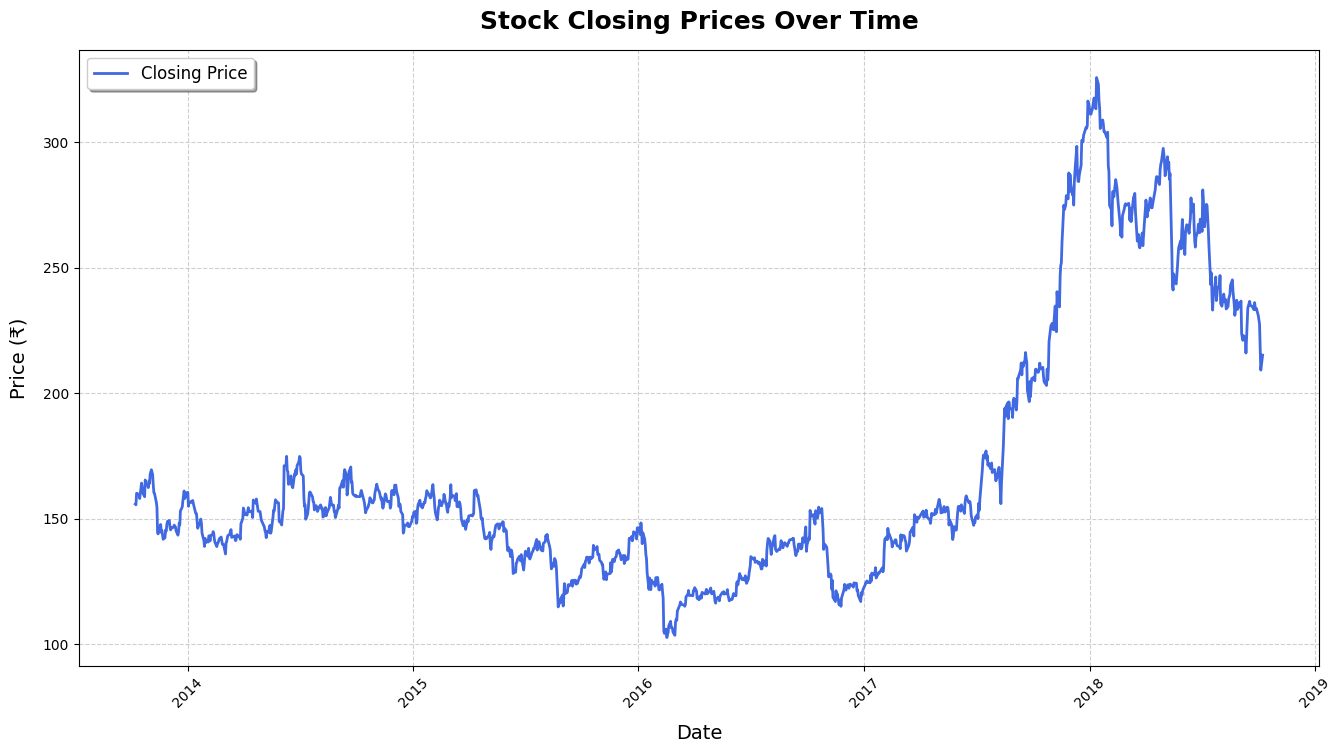

In [36]:
# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Convert to datetime if not already

# Set Date as index for proper x-axis labeling
data.set_index('Date', inplace=True)

# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['Close'], label='Closing Price', linewidth=2, color='royalblue')

# Adding a title and labels
plt.title("Stock Closing Prices Over Time", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Date", fontsize=14, labelpad=10)
plt.ylabel("Price (₹)", fontsize=14, labelpad=10)

# Improve x-axis formatting
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

# Show the plot
plt.show()


**Feature Engineering: Creating New Variables**

In this step, we generate new features from the existing stock price data to help improve predictive modeling. Specifically:

1. **`Open - Close`**: The difference between the opening and closing price for each day, which indicates the intraday price movement.
2. **`High - Low`**: The difference between the highest and lowest price of the day, which captures the daily price range.

We then:
- **Remove any missing values** from the dataset.
- **Select these two new features (`X`)** for further analysis.

The resulting dataset (`X`) will now contain only these two columns, ready for use in modeling or visualization.

In [37]:
# Create a new column: Difference between Open and Close price
data['Open - Close'] = data['Open'] - data['Close']

# Create a new column: Difference between High and Low price
data['High - Low'] = data['High'] - data['Low']

# Drop any rows with missing values (NaN) to ensure clean data
data  = data.dropna()

# Select only the newly created features for further analysis
X = data[['Open - Close', 'High - Low']]
X.head()

,Open - Close,High - Low
Date,,
2018-10-08,-7.15,15.40
2018-10-05,7.80,12.70
2018-10-04,5.30,11.65
2018-10-03,2.40,11.75
2018-10-01,3.65,13.55


**Generating Target Variable (`Y`) for Buy/Sell Signals**

In this step, we define a **trading signal** based on the stock's closing price movement:

- **+1 (Buy Signal)** → If the next day's closing price (`Close.shift(-1)`) is **higher** than today's closing price.
- **-1 (Sell Signal)** → If the next day's closing price is **lower** than today's closing price.

This creates a **binary classification problem** where:
- `+1` suggests a price increase (buy).
- `-1` suggests a price decrease (sell).

This `Y` variable will serve as the **target variable** for a machine learning model.


In [38]:
# Generate target variable (Y) for buy (+1) and sell (-1) signals
# If tomorrow's closing price is higher than today's, label as +1 (buy), otherwise -1 (sell)
Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)

Y[:10]

array([-1,  1,  1,  1,  1, -1,  1,  1, -1,  1])

### **Using TimeSeriesSplit for Time Series Classification**
In this cell, we use **TimeSeriesSplit** to properly split our dataset for **time series classification**. Unlike traditional **train-test splits** (e.g., `train_test_split`), time series data has a **temporal order**, meaning that **future data should never be used to train a model predicting the past**. 

#### **Why Use `TimeSeriesSplit`?**
- **Prevents data leakage**: Ensures that training data always precedes testing data, which mimics real-world predictions where future information is unavailable at training time.
- **Allows multiple train-test splits**: By setting `n_splits=5`, we perform **5 different train-test splits**, progressively increasing the training data size while keeping the test data forward-looking.

#### **What This Cell Does**
1. **Initializes `TimeSeriesSplit(n_splits=5)`**: This will generate 5 different training and testing sets.
2. **Imports K-Nearest Neighbors (KNN) classifier**: We will use KNN to classify stock movements based on selected features.
3. **Imports performance metrics (`accuracy_score`, `classification_report`, `confusion_matrix`)**: These help evaluate the classifier's effectiveness.
4. **Splits the dataset into multiple training and testing sets**:
   - `X_train`, `X_test` → Features for training/testing
   - `y_train`, `y_test` → Labels for training/testing

This approach ensures our model is tested **only on unseen future data**, preventing **look-ahead bias** and ensuring a more realistic performance evaluation.


In [39]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Number of splits

# Import KNN and evaluation metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Perform train-test split using TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


### **Training a Basic K-Nearest Neighbors (KNN) Model**
In this cell, we **train a basic KNN classifier** to predict **buy/sell signals** in our stock dataset. We **randomly select `k=5`** as the number of neighbors, meaning each prediction is based on the **5 nearest data points in the feature space**.

#### **Why We Are Not Tuning `k` Here**
- **No hyperparameter tuning is performed** in this step.
- We **randomly select `k=5`** to **quickly train and evaluate** a baseline model.
- Later, we can optimize `k` using **the Elbow Method**.

#### **What This Cell Does**
1. **Initializes the KNN model** with `n_neighbors=5`.
2. **Trains the model** using the `fit(X_train, y_train)` function.
3. **Generates predictions** for the test set (`X_test`).
4. **Evaluates model performance** using:
   - **Accuracy Score** → Measures overall correctness.
   - **Precision, Recall, and F1-Score** → Provide a detailed classification analysis.

#### **Results and Interpretation**


- **Overall accuracy is 84.39%**, meaning the model correctly classifies buy/sell signals **84.39% of the time**.
- **Precision (0.85 for -1, 0.84 for 1)**:
  - If KNN predicts **Sell (-1)**, it is correct **85% of the time**.
  - If KNN predicts **Buy (1)**, it is correct **84% of the time**.
- **Recall (0.83 for -1, 0.86 for 1)**:
  - The model correctly **identifies 83% of actual Sell (-1) signals**.
  - The model correctly **identifies 86% of actual Buy (1) signals**.
- **F1-Score (~0.84 for both classes)** indicates a good balance between **precision and recall**.

#### **Next Steps**
- **Hyperparameter tuning** → Optimize `k` to see if we can improve performance.


In [60]:
# Train a basic KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8439
              precision    recall  f1-score   support

          -1       0.85      0.83      0.84        99
           1       0.84      0.86      0.85       106

    accuracy                           0.84       205
   macro avg       0.84      0.84      0.84       205
weighted avg       0.84      0.84      0.84       205



### **Confusion Matrix Visualization for KNN Classifier**
In this cell, we generate a **confusion matrix** to evaluate how well our **K-Nearest Neighbors (KNN) classifier** predicts **buy (+1) and sell (-1) signals**.

#### **Why Use a Confusion Matrix?**
- A **confusion matrix** helps us understand the types of errors our model makes.
- Instead of just looking at **accuracy**, this allows us to analyze **false positives and false negatives**.

#### **What This Cell Does**
1. **Computes the Confusion Matrix** using:
   ```python
   cm = confusion_matrix(y_test, y_pred)


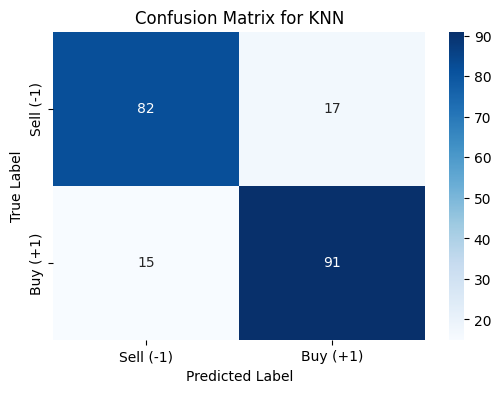

In [41]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Sell (-1)', 'Buy (+1)'], yticklabels=['Sell (-1)', 'Buy (+1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN")
plt.show()


### **Elbow Method for Optimal `k` Selection**
In this cell, we use the **Elbow Method** to determine the **optimal number of neighbors (`k`)** for our **K-Nearest Neighbors (KNN) classifier**.

#### **Why is Selecting the Right `k` Important?**
- **Too small `k` (e.g., 1-3)** → Leads to **high variance**, meaning the model is **too sensitive** to noise.
- **Too large `k` (e.g., 15-20)** → Leads to **high bias**, meaning the model is **too smooth** and might overlook important details.
- The **goal** is to find the **"elbow point"**, where adding more neighbors **doesn’t significantly reduce error**.

#### **What This Cell Does**
1. **Iterates over different values of `k`** (from `1` to `20`).
2. **Trains a KNN classifier for each `k`**:
   - Uses **TimeSeriesSplit (TSCV)** to ensure training and testing respect the **temporal order**.
   - Measures **accuracy** for each split.
   - Computes **error rate** as `1 - accuracy` (lower is better).
3. **Plots the error rate vs. `k`**:
   - The **X-axis represents different values of `k`**.
   - The **Y-axis represents the error rate**.
   - The **optimal `k` is found at the "elbow" point**, where error rate stops decreasing significantly.

#### **Interpreting the Results**
- The plot shows that **the error rate initially decreases** as `k` increases.
- Around `k = 9`, the error rate stops decreasing significantly.
- **Optimal `k` = 9**, because it provides a good balance between **bias and variance**.


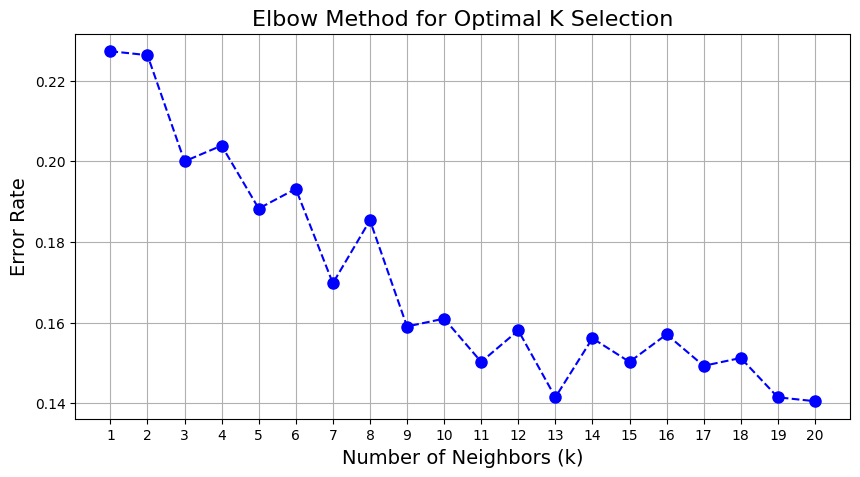

In [42]:
# Elbow Method for Optimal K Selection
k_values = range(1, 21)
error_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        acc_scores.append(accuracy_score(y_test, y_pred))
    
    # Compute error rate (1 - accuracy)
    avg_accuracy = np.mean(acc_scores)
    error_rates.append(1 - avg_accuracy)

# Plot the Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(k_values, error_rates, marker='o', linestyle='dashed', color='b', markersize=8)
plt.xlabel("Number of Neighbors (k)", fontsize=14)
plt.ylabel("Error Rate", fontsize=14)
plt.title("Elbow Method for Optimal K Selection", fontsize=16)
plt.xticks(k_values)
plt.grid(True)
plt.show()


### **Training KNN with the Optimal `k=9`**
After using the **Elbow Method**, we determined that the **best value for `k` is 9**. In this step, we **train and evaluate the optimized KNN model** using `k=9` to see if it improves performance.

#### **What This Cell Does**
1. **Initializes KNN with `k=9`**:  
   ```python
   knn_best = KNeighborsClassifier(n_neighbors=9)
   ```
   - Instead of the previously random `k=5`, we now use the optimized `k=9`.

2. **Trains the model on the training data**:  
   ```python
   knn_best.fit(X_train, y_train)
   ```
   - The classifier learns from historical stock data.

3. **Generates predictions on the test data**:  
   ```python
   y_pred_best = knn_best.predict(X_test)
   ```

4. **Evaluates performance using key metrics**:  
   ```python
   print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
   print(classification_report(y_test, y_pred_best))
   ```
   - Computes **accuracy, precision, recall, and F1-score** to assess classification quality.

---

### **Comparing Results: `k=5` vs. `k=9`**
| Metric       | `k=5` (Initial Model) | `k=9` (Optimized Model) |
|-------------|---------------------|----------------------|
| **Accuracy** | **0.8439**           | **0.8634**           |
| **Precision (-1)** | 0.85 | **0.87** |
| **Recall (-1)** | 0.83 | **0.85** |
| **F1-score (-1)** | 0.84 | **0.86** |
| **Precision (+1)** | 0.84 | **0.86** |
| **Recall (+1)** | 0.86 | **0.88** |
| **F1-score (+1)** | 0.85 | **0.87** |

#### **Observations**
- **Accuracy improved from 84.39% (`k=5`) to 86.34% (`k=9`)**.
- **Precision, Recall, and F1-scores increased for both buy (+1) and sell (-1) classes**.
- **Lower False Positives and False Negatives**, meaning fewer misclassifications.
- **Balanced improvement across all metrics**, confirming that `k=9` is a better choice.

#### **Why Did `k=9` Perform Better?**
- With `k=5`, the model might have been **overfitting**, relying too much on a small number of neighbors.
- Increasing `k` to `9` **smooths predictions**, reducing sensitivity to noisy data points.
- The Elbow Method helped find a balance between **bias and variance**, leading to better generalization.

---



In [44]:
# Train KNN with the best k
knn_best = KNeighborsClassifier(n_neighbors=9)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

# Final model evaluation
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))

Optimized Accuracy: 0.8634
              precision    recall  f1-score   support

          -1       0.87      0.85      0.86        99
           1       0.86      0.88      0.87       106

    accuracy                           0.86       205
   macro avg       0.86      0.86      0.86       205
weighted avg       0.86      0.86      0.86       205



### **Visualizing Buy/Sell Predictions on Stock Price**
This cell **plots the KNN classifier's buy/sell predictions** over the stock's closing price. Instead of evaluating accuracy with numbers, we use a **scatter plot overlay** to visually inspect how well the classifier identifies trading opportunities.

#### **What This Cell Does**
1. **Plots the stock price (blue line)**:
   ```python
   plt.plot(data.index[-len(y_test):], data['Close'].iloc[-len(y_test):], label="Stock Price", color="royalblue", linewidth=2)
   ```
   - This provides the reference stock price trend.

2. **Identifies Buy & Sell Signals**:
   ```python
   buy_signals = data.index[-len(y_test):][y_pred_best == 1]
   sell_signals = data.index[-len(y_test):][y_pred_best == -1]
   ```
   - The model predicts buy signals (`+1`) and sell signals (`-1`).

3. **Plots Buy (Green) and Sell (Red) Signals**:
   ```python
   plt.scatter(buy_signals, data['Close'].iloc[-len(y_test):][y_pred_best == 1], marker="^", color="green", label="Buy Signal", alpha=1, s=100)
   plt.scatter(sell_signals, data['Close'].iloc[-len(y_test):][y_pred_best == -1], marker="v", color="red", label="Sell Signal", alpha=1, s=100)
   ```
   - **Green triangles (`^`) mark buy opportunities**.
   - **Red inverted triangles (`v`) mark sell signals**.

4. **Adds Labels and Formatting**:
   ```python
   plt.title("KNN Buy/Sell Predictions on Stock Price", fontsize=16)
   plt.xlabel("Date")
   plt.ylabel("Stock Price (₹)")
   plt.legend()
   plt.grid(True)
   plt.show()
   ```
   - A well-formatted graph helps visualize the effectiveness of the model.

#### **Interpreting the Plot**
- **If the buy signals (`^`) occur before price increases**, the model is making useful predictions.
- **If sell signals (`v`) appear before price drops**, the model is effectively identifying downturns.
- **If buy/sell signals appear randomly**, further tuning or feature engineering may be needed.

#### **Next Steps**
- **Compare buy/sell predictions with actual stock movements**.
- **Tune hyperparameters further** to refine accuracy.
- **Explore additional features** like moving averages to improve signal reliability.
```



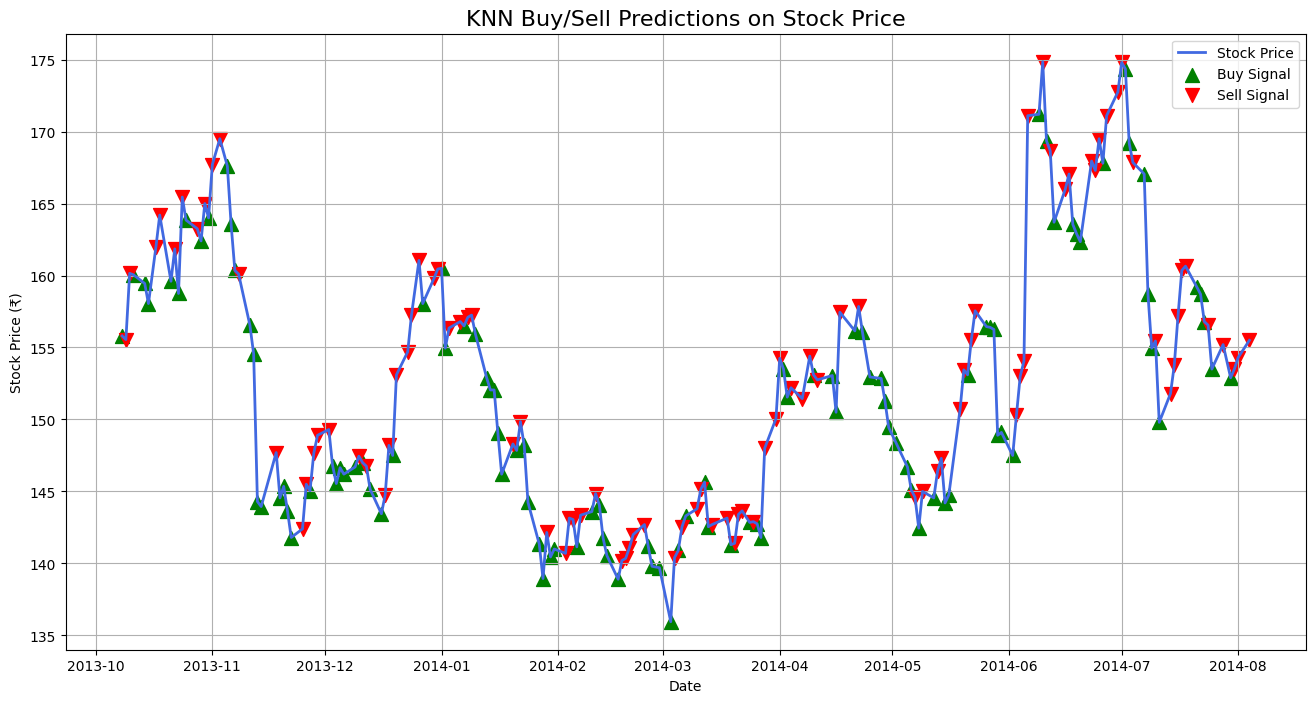

In [46]:
# Scatter Plot for Buy/Sell Predictions on Closing Price Chart
plt.figure(figsize=(16, 8))
plt.plot(data.index[-len(y_test):], data['Close'].iloc[-len(y_test):], label="Stock Price", color="royalblue", linewidth=2)

# Plot buy signals
buy_signals = data.index[-len(y_test):][y_pred_best == 1]
sell_signals = data.index[-len(y_test):][y_pred_best == -1]

plt.scatter(buy_signals, data['Close'].iloc[-len(y_test):][y_pred_best == 1], marker="^", color="green", label="Buy Signal", alpha=1, s=100)
plt.scatter(sell_signals, data['Close'].iloc[-len(y_test):][y_pred_best == -1], marker="v", color="red", label="Sell Signal", alpha=1, s=100)

plt.title("KNN Buy/Sell Predictions on Stock Price", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price (₹)")
plt.legend()
plt.grid(True)
plt.show()


### **Rolling Accuracy of KNN Predictions**
This cell **calculates and visualizes the rolling accuracy** of our KNN classifier over a **30-day window**. Instead of evaluating accuracy as a single number, we plot how accuracy fluctuates over time.

#### **Why Use Rolling Accuracy?**
- Accuracy may **vary over different periods** due to market conditions.
- A **moving window approach** helps detect trends in model performance.
- It allows us to identify **time periods where the model struggles or excels**.

#### **What This Cell Does**
1. **Computes rolling accuracy over a 30-day window**:
   ```python
   window_size = 30
   rolling_accuracy = pd.Series(y_test == y_pred_best, index=data.index[-len(y_test):]).rolling(window=window_size).mean()
   ```
   - A rolling window of **30 days** is applied to calculate **local accuracy trends**.
   - This smooths out daily fluctuations and highlights **overall trends**.

2. **Plots rolling accuracy over time**:
   ```python
   plt.plot(rolling_accuracy, label="Rolling Accuracy (30-day)", color="green", linewidth=2)
   ```
   - **Green line** shows how the model's accuracy **changes over time**.

3. **Adds a reference line for overall accuracy**:
   ```python
   plt.axhline(y=np.mean(y_test == y_pred_best), color="black", linestyle="--", label="Overall Accuracy")
   ```
   - The **black dashed line** represents the **average accuracy** across all test data.
   - Helps compare short-term performance to the long-term mean.

4. **Formats the plot for readability**:
   ```python
   plt.xlabel("Date")
   plt.ylabel("Accuracy")
   plt.title("Rolling Accuracy of KNN Predictions", fontsize=16)
   plt.legend()
   plt.grid(True)
   plt.show()
   ```
   - Labels, title, and grid improve **interpretability**.



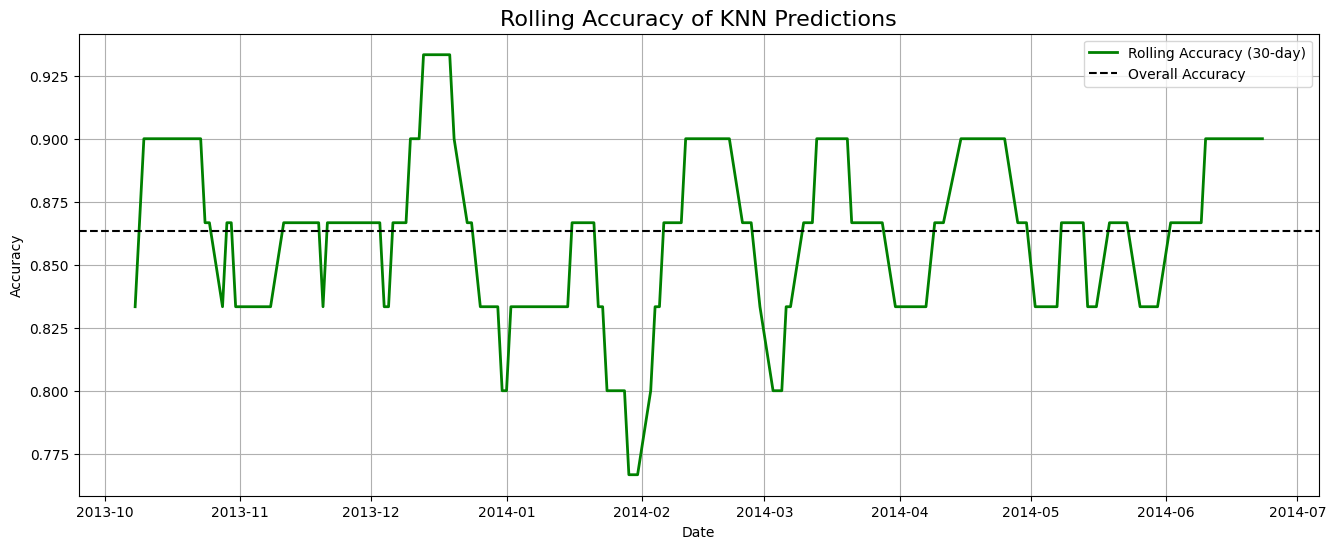

In [47]:
window_size = 30  # Moving window of 30 days
rolling_accuracy = pd.Series(y_test == y_pred_best, index=data.index[-len(y_test):]).rolling(window=window_size).mean()

# Plot Rolling Accuracy
plt.figure(figsize=(16, 6))
plt.plot(rolling_accuracy, label="Rolling Accuracy (30-day)", color="green", linewidth=2)
plt.axhline(y=np.mean(y_test == y_pred_best), color="black", linestyle="--", label="Overall Accuracy")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.title("Rolling Accuracy of KNN Predictions", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### **Visualizing KNN Decision Boundary**
This cell **plots the decision boundary** of our **K-Nearest Neighbors (KNN) classifier** to illustrate how the model classifies buy (+1) and sell (-1) signals.

#### **Why Visualize the Decision Boundary?**
- Helps **understand how KNN makes predictions** based on the two selected features.
- Shows **which areas of the feature space are classified as buy or sell zones**.
- Allows us to **see how test data aligns** with the trained model's predictions.

#### **What This Cell Does**
1. **Creates a mesh grid for visualization**:
   ```python
   x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
   y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
   xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
   ```
   - Defines the **range of values** for the `Open - Close` and `High - Low` features.
   - Generates a **grid of points** to map decision boundaries.

2. **Trains the KNN classifier using the best `k=9`**:
   ```python
   knn_best = KNeighborsClassifier(n_neighbors=9)
   knn_best.fit(X_train, y_train)
   ```
   - Uses the **optimized `k=9`** from the Elbow Method.

3. **Predicts the classification for each point in the grid**:
   ```python
   Z = knn_best.predict(np.c_[xx.ravel(), yy.ravel()])
   Z = Z.reshape(xx.shape)
   ```
   - Assigns **buy or sell classifications** to each point in the mesh grid.

4. **Plots the decision boundary**:
   ```python
   cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF"])
   plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
   ```
   - **Red area** represents the model's **predicted sell zones**.
   - **Blue area** represents the model's **predicted buy zones**.

5. **Plots the actual training and testing data points**:
   ```python
   plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=ListedColormap(["red", "blue"]), edgecolor="k", s=60, label="Train Data")
   plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap=ListedColormap(["red", "blue"]), marker="*", edgecolor="k", s=120, label="Test Data")
   ```
   - **Red circles** represent training data points classified as **sell (-1)**.
   - **Blue circles** represent training data points classified as **buy (+1)**.
   - **Red stars and blue stars** show the **test data points** and their classifications.

6. **Formats the plot for better readability**:
   ```python
   plt.xlabel("Open - Close")
   plt.ylabel("High - Low")
   plt.title(f"KNN Decision Boundary (k={9})")
   plt.legend()
   plt.grid(True)
   plt.show()
   ```
   - Labels and legend clarify **feature axes and data point categories**.

#### **Interpreting the Plot**
- **If test data aligns well with the decision regions**, the model is making sensible classifications.
- **If test points are scattered across decision boundaries**, the model may struggle with generalization.
- **Sharp or irregular boundary shapes** could indicate **overfitting or sensitivity to noise**.
```



/Users/aleckovice/opt/anaconda3/envs/a4_ml/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


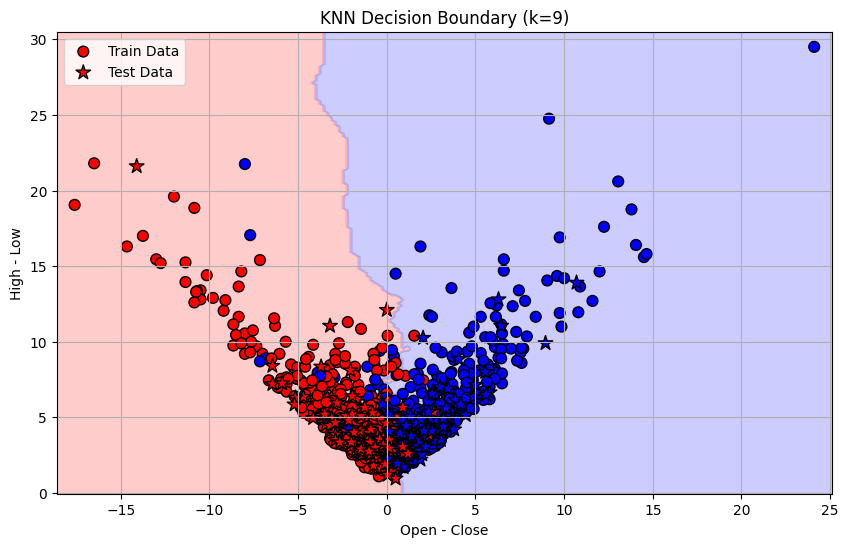

In [52]:

from matplotlib.colors import ListedColormap

# Create a mesh grid for visualization
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Train KNN classifier with best k
knn_best = KNeighborsClassifier(n_neighbors=9)
knn_best.fit(X_train, y_train)

# Predict the classification for each point in the grid
Z = knn_best.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF"])
cmap_bold = ["red", "blue"]

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)  # Decision boundary

# Plot training points
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=ListedColormap(cmap_bold), edgecolor="k", s=60, label="Train Data")

# Plot testing points
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap=ListedColormap(cmap_bold), marker="*", edgecolor="k", s=120, label="Test Data")

plt.xlabel("Open - Close")
plt.ylabel("High - Low")
plt.title(f"KNN Decision Boundary (k={9})")
plt.legend()
plt.grid(True)
plt.show()
